# Lab 3: Bayes Classifier and Boosting

## Jupyter notebooks

In this lab, you can use Jupyter <https://jupyter.org/> to get a nice layout of your code and plots in one document. However, you may also use Python as usual, without Jupyter.

If you have Python and pip, you can install Jupyter with `sudo pip install jupyter`. Otherwise you can follow the instruction on <http://jupyter.readthedocs.org/en/latest/install.html>.

And that is everything you need! Now use a terminal to go into the folder with the provided lab files. Then run `jupyter notebook` to start a session in that folder. Click `lab3.ipynb` in the browser window that appeared to start this very notebook. You should click on the cells in order and either press `ctrl+enter` or `run cell` in the toolbar above to evaluate all the expressions.

Be sure to put `%matplotlib inline` at the top of every code cell where you call plotting functions to get the resulting plots inside the document.

## Import the libraries

In Jupyter, select the cell below and press `ctrl + enter` to import the needed libraries.
Check out `labfuns.py` if you are interested in the details.

In [48]:
import numpy as np
from scipy import misc
from imp import reload
from labfuns import *
import random
import seaborn as sns
import math 

## Bayes classifier functions to implement

The lab descriptions state what each function should do.

In [49]:
# NOTE: you do not need to handle the W argument for this part!
# in: labels - N vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels, W=None):
    Npts = labels.shape[0]
    if W is None:
        W = np.ones((Npts,1))/Npts
    else:
        assert(W.shape[0] == Npts)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    prior = np.zeros((Nclasses,1))

    #Assignment 5 
    for i in range(Nclasses): 
        filter = (labels == classes[i])
        prior[i] = np.sum(W[filter]) / np.sum(W)

    """
    Prior to assingment 5
    for i in range(Nclasses): 
        class_count = class_count = np.count_nonzero(labels == classes[i])
        prior[i] = class_count / Npts
    """
    return prior

# NOTE: you do not need to handle the W argument for this part!
# in:      X - N x d matrix of N data points
#     labels - N vector of class labels
# out:    mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
def mlParams(X, labels, W=None):

    #Assignment 4 implementation with weights
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    #W = np.full((Npts, 1), 1/Npts)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones((Npts,1))/float(Npts)

    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))

    #its the amount of times that label appears divided by the number of items in that class. 


    #MU Calculation
    for i in range(Nclasses): 
        filter = (labels == classes[i])
        xw = X[filter] * W[filter]
        w_count = np.sum(W[filter])
        mu[i] = np.sum(xw, axis=0) / w_count

    #SIGMA Calculation
    for i in range(Nclasses): 
        filter = (labels == classes[i])
        w_count = np.sum(W[filter])
        class_data = X[filter] 
        class_data = class_data - mu[i]
        class_data = np.square(class_data)
        class_data = class_data * W[filter]
        class_data = np.sum(class_data, axis=0) / w_count
        sigma[i] = np.diag(class_data)

    """
    WITHOUT WEIGHTS - before assignment 4
    #MU Calculation
    for i in range(Nclasses): 
        class_count = np.count_nonzero(labels == classes[i])
        filter = (labels == classes[i])
        mu[i] = np.sum(X[filter], axis=0) / class_count
    
    #SIGMA Calculation
    for i in range(Nclasses): 
        class_count = np.count_nonzero(labels == classes[i])
        filter = (labels == classes[i])
        class_data = X[filter] 
        class_data = class_data - mu[i]
        class_data = np.square(class_data)
        class_data = np.sum(class_data, axis=0) / class_count
        sigma[i] = np.diag(class_data)
    """

    return mu, sigma

# in:      X - N x d matrix of M data points
#      prior - C x 1 matrix of class priors
#         mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
# out:     h - N vector of class predictions for test points
def classifyBayes(X, prior, mu, sigma):

    Npts = X.shape[0]
    Nclasses,Ndims = np.shape(mu)
    logProb = np.zeros((Nclasses, Npts))

    for i in range(Nclasses): 
        n_covar = - 0.5 * np.log(np.linalg.det(sigma[i]))
        diff = X - mu[i]
        inv_sig = np.linalg.inv(sigma[i])
        pr = np.log(prior[i])
        for j in range(Npts): 
            res = -0.5*np.dot(np.dot((X[j]-mu[i]), inv_sig), (X[j]-mu[i]).transpose())  
            logProb[i][j] = n_covar + res + pr
        

        """
        more efficient way than nested loop
        res = - (np.dot(np.dot(diff, inv_sig), np.transpose(diff)) / 2)
        logProb = n_covar + res + pr
        print(logProb)
        """
    # one possible way of finding max a-posteriori once
    # you have computed the log posterior
    h = np.argmax(logProb,axis=0)
    return h

X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels)
prior = computePrior(labels)
test = classifyBayes(X, prior, mu, sigma)


The implemented functions can now be summarized into the `BayesClassifier` class, which we will use later to test the classifier, no need to add anything else here:

In [50]:
# NOTE: no need to touch this
class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

## Test the Maximum Likelihood estimates

Call `genBlobs` and `plotGaussian` to verify your estimates.

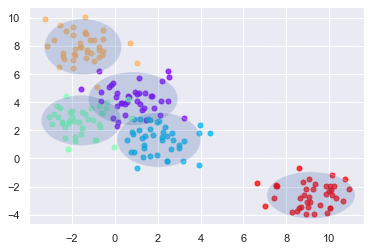

In [51]:
%matplotlib inline

X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels)
plotGaussian(X,labels,mu,sigma)

Call the `testClassifier` and `plotBoundary` functions for this part.

In [52]:
testClassifier(BayesClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 84.4
Trial: 10 Accuracy 95.6
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 86.7
Trial: 40 Accuracy 88.9
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 86.7
Trial: 70 Accuracy 91.1
Trial: 80 Accuracy 86.7
Trial: 90 Accuracy 91.1
Final mean classification accuracy  89 with standard deviation 4.16


In [53]:
testClassifier(BayesClassifier(), dataset='vowel', split=0.7)

Trial: 0 Accuracy 61
Trial: 10 Accuracy 66.2
Trial: 20 Accuracy 74
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 64.3
Trial: 60 Accuracy 66.9
Trial: 70 Accuracy 63.6
Trial: 80 Accuracy 62.3
Trial: 90 Accuracy 70.8
Final mean classification accuracy  64.7 with standard deviation 4.03


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

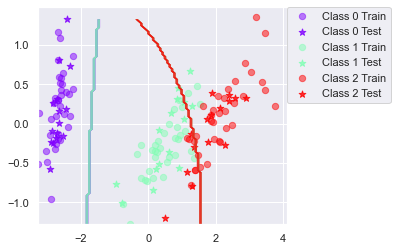

In [7]:
%matplotlib inline
plotBoundary(BayesClassifier(), dataset='iris',split=0.7)

## Assignment 3 Questions

#### 1. When can a feature independence assumption be reasonable and when not?
NB assumes features are conditonally independent i.e. given the label, events A and B are independent. 

Usually the feature dependence assumption does not hold. However, it is reasonable to make this assumption when the correlations are small. These small positive and negative correlations will cancel eachother out. Additionally, this assumption is reasonable when the dependencies are distrbuted evenly in classes

NB will perform poorly when there is a high correlation between classes. 

#### 2. How does the decision boundary look for the Iris dataset? How could one improve the classication results for this scenario by changing classier or, alternatively, manipulating the data?

The bounday for the irish data set is not comepletely accurate. There is good seperation between class 0 and the other two classes however, the seperation between class 1 and 2 is not well defined. It may be better in this case to use an SVM that could seperate these classes by seperating them in a higher dimension. 

Alternatively, NB is susceptible to the 'zero frequency problem' where categories that don't appear in the training data will have a probability of zero. Therefore, test data with these labels are classified incorrectly. A solution to this is to use laplace smoothing wso that no probability is ever 0. 



## Boosting functions to implement

The lab descriptions state what each function should do.

In [54]:
# in: base_classifier - a classifier of the type that we will boost, e.g. BayesClassifier
#                   X - N x d matrix of N data points
#              labels - N vector of class labels
#                   T - number of boosting iterations
# out:    classifiers - (maximum) length T Python list of trained classifiers
#              alphas - (maximum) length T Python list of vote weights
"""
def trainBoost(base_classifier, X, labels, T=10):
    # these will come in handy later on
    Npts,Ndims = np.shape(X)

    classifiers = [] # append new classifiers to this list
    alphas = [] # append the vote weight of the classifiers to this list

    # The weights for the first iteration
    wCur = np.ones((Npts,1))/float(Npts)
    #wCur = wCur.flatten()
    
    
    for i_iter in range(0, T):
        # a new classifier can be trained like this, given the current weights
      
        classifiers.append(base_classifier.trainClassifier(X, labels, wCur))
    
        # do classification for each point
        vote = classifiers[-1].classify(X)

        # TODO: Fill in the rest, construct the alphas etc.
        # ==========================

        filter = labels != vote
        err = np.sum(wCur[filter])
        if err==0.0:
            err = 0.0001
        alpha = 0.5 * (np.log(1 - err) - np.log(err))
        alphas.append(alpha)
        # update the weights 
        #print("vote shape")
        #print(vote.shape)

        weight_change = -alpha * labels * vote
        #print("weight_change_hape")
        #print((weight_change.reshape(len(weight_change),1)).shape)
        exp_weight = np.exp(weight_change)
        #print("exp_weight_shape")
        #print(exp_weight.shape)
        #print("weight_shape")
        #print(exp_weight)
        wCur = wCur.flatten()
        wCur = np.multiply(wCur,exp_weight)
        wCur = wCur.reshape(len(wCur),1)
        
        # ==========================
    return classifiers, alphas
"""
def trainBoost(base_classifier, X, labels, T=10):
    # these will come in handy later on
    Npts,Ndims = np.shape(X)

    classifiers = [] # append new classifiers to this list
    alphas = [] # append the vote weight of the classifiers to this list

    # The weights for the first iteration
    wCur = np.ones((Npts,1))/float(Npts)

    for i_iter in range(0, T):
        # a new classifier can be trained like this, given the current weights
        classifiers.append(base_classifier.trainClassifier(X, labels, wCur))

        # do classification for each point
        vote = classifiers[-1].classify(X)

        # TODO: Fill in the rest, construct the alphas etc.
        # ==========================
        error = 0
        for i in range(len(vote)):
            wCur_i = wCur[i]
            label_i = labels[i]
            vote_i = vote[i]
            
            if(vote_i==label_i):		
                delta=1
        
        
            else:	delta=0
            error = error + wCur_i*(1-delta)
        if error==0.0:
            error = 0.0001
        
        #print error
        alpha = 0.5*(math.log(1-error)-math.log(error))
        for i in range(len(X)):
            if(vote[i] == labels[i]):
                omegaWeight=math.exp(-alpha)
            else: 
                omegaWeight=math.exp(alpha)
            wCur[i] *= omegaWeight
        wCur /= np.sum(wCur)
        alphas.append(alpha) # you will need to append the new alpha
        # ==========================
        
    return classifiers, alphas



# in:       X - N x d matrix of N data points
# classifiers - (maximum) length T Python list of trained classifiers as above
#      alphas - (maximum) length T Python list of vote weights
#    Nclasses - the number of different classes
# out:  yPred - N vector of class predictions for test points
def classifyBoost(X, classifiers, alphas, Nclasses):
    Npts = X.shape[0]
    Ncomps = len(classifiers)

    # if we only have one classifier, we may just classify directly
    if Ncomps == 1:
        return classifiers[0].classify(X)
    else:
        votes = np.zeros((Npts,Nclasses))

        # TODO: implement classificiation when we have trained several classifiers!
        # here we can do it by filling in the votes vector with weighted votes
        # ==========================
      
        for i in range(Ncomps):
            vote = classifiers[i].classify(X)
            for j in range(Npts):
                index = vote[j]
                votes[j][index] += alphas[i]
        # ==========================

        # one way to compute yPred after accumulating the votes
        return np.argmax(votes,axis=1)

The implemented functions can now be summarized another classifer, the `BoostClassifier` class. This class enables boosting different types of classifiers by initializing it with the `base_classifier` argument. No need to add anything here.

In [56]:
# NOTE: no need to touch this
class BoostClassifier(object):
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        rtn = BoostClassifier(self.base_classifier, self.T)
        rtn.nbr_classes = np.size(np.unique(labels))
        rtn.classifiers, rtn.alphas = trainBoost(self.base_classifier, X, labels, self.T)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBoost(X, self.classifiers, self.alphas, self.nbr_classes)

## Run some experiments

Call the `testClassifier` and `plotBoundary` functions for this part.

In [57]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 97.8
Trial: 50 Accuracy 93.3
Trial: 60 Accuracy 93.3
Trial: 70 Accuracy 97.8
Trial: 80 Accuracy 95.6
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.7 with standard deviation 2.82


In [58]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 76.6
Trial: 10 Accuracy 86.4
Trial: 20 Accuracy 83.1
Trial: 30 Accuracy 80.5
Trial: 40 Accuracy 72.7
Trial: 50 Accuracy 76
Trial: 60 Accuracy 81.8
Trial: 70 Accuracy 82.5
Trial: 80 Accuracy 79.9
Trial: 90 Accuracy 83.1
Final mean classification accuracy  80.2 with standard deviation 3.52


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

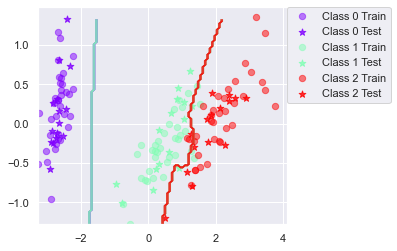

In [59]:
%matplotlib inline
plotBoundary(BoostClassifier(BayesClassifier()), dataset='iris',split=0.7)

Now repeat the steps with a decision tree classifier.

In [60]:
testClassifier(DecisionTreeClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 91.1
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 88.9
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 88.9
Final mean classification accuracy  92.4 with standard deviation 3.71


In [41]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 95.6
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 95.6
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 93.3
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.6 with standard deviation 3.65


In [42]:
testClassifier(DecisionTreeClassifier(), dataset='vowel',split=0.7)

Trial: 0 Accuracy 63.6
Trial: 10 Accuracy 68.8
Trial: 20 Accuracy 63.6
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 63
Trial: 60 Accuracy 59.7
Trial: 70 Accuracy 68.8
Trial: 80 Accuracy 59.7
Trial: 90 Accuracy 68.2
Final mean classification accuracy  64.1 with standard deviation 4


In [43]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 85.1
Trial: 10 Accuracy 89.6
Trial: 20 Accuracy 87
Trial: 30 Accuracy 92.2
Trial: 40 Accuracy 84.4
Trial: 50 Accuracy 80.5
Trial: 60 Accuracy 86.4
Trial: 70 Accuracy 85.7
Trial: 80 Accuracy 89
Trial: 90 Accuracy 83.1
Final mean classification accuracy  86.6 with standard deviation 2.86


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

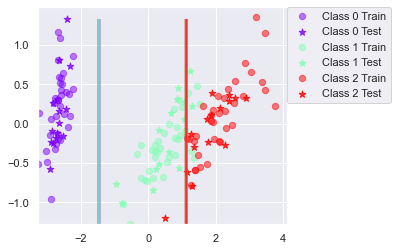

In [44]:
%matplotlib inline
plotBoundary(DecisionTreeClassifier(), dataset='iris',split=0.7)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

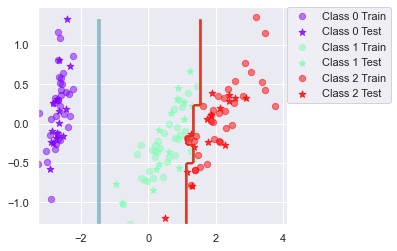

In [47]:
%matplotlib inline
plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

## Assignment 5: Questions

#### Compute the classication accuracy of the boosted classier on some data sets using testClassifier from labfuns.py and compare it with those of the basic classier on the vowels and iris data sets

#### (1) Is there any improvement in classication accuracy? Why/why not?

Yes there is an imporvement when using the boosted classifier. The accuracy on teh Iris test set rose from 89 to 94.1. The accuracy on the vowel rose from 64.7 to 80.2. 
Boosting improves results by combining a number of weak learners (high bias and low variance).  When these learners are aggregated they are create a model with higher performance (low bias, low variance)

#### (2) Plot the decision boundary of the boosted classier on iris and compare it with that of the basic. What differences do you notice? Is the boundary of the boosted version more complex?

The decision boundary for the boosted model is more compelx. The boundary is less smooth but classfies both the training and test data with greater accuracy. 

#### (3) Can we make up for not using a more advanced model in the basic classier(e.g. independent features) by using boosting?

Yes by using using boosting we can combine a number of weak learners to create a surperior model.

### For The Decision Tree

#### (1) Is there any improvement in classication accuracy? Why/why not?
There isnt a huge difference between the basic and boosted decision tree performance on the iris data set. The basic moel already performed well with an accuracy of 92.4 whle the boosted gave a 2.2% improvement (94.6%)

For the vowel data set the imporvement was much more significant. The accuracy rose from 64.1 to 86.6. 

You can see that the basic decision tree was enough for the Iris dataset while the vowel data. This may be because the boosted decision tree peforms well when there is high variance in the training dataset which a basic tree may struggle with (they are unstable)


#### (2) Plot the decision boundary of the boosted classier on iris and compare it with that of the basic. What differences do you notice? Is the boundary of the boosted version more complex?

You can see that the basic model has a high bias, using a vertical lien to split the data. The boosted model's boundary is more complex, and correctly classfies the outliers

#### (3) Can we make up for not using a more advanced model in the basic classier(e.g. independent features) by using boosting?

Yes by using using boosting we can combine a number of weak learners to create a surperior model.

## Assingment 7 : Questions

If you had to pick a classier, naive Bayes or a decision tree or the boosted versions of these, which one would you pick? Motivate from the following criteria:
 - #### Outliers

   Naive Bayes: Yes outliers affect naive bayes becuase they could distort the distributions e.g. the mean and variance. In addtion outliers in the test dat acan cause issues. If they are not represented in tehe trainign set tehy will have a probability of zero - use laplace smoothing
   Decision Trees: Most likely outliers will have a negligible effect because the nodes are determined based on the sample proportions in each split region (and not on their absolute         values).

   Verdict: Decision trees better
    
 - #### Irrelevant inputs: part of the feature space is irrelevant

    Naive Bayes: The likihood will be low for irrelevant featrues
    Decision trees: have built in feature selection i.e. calulation of the information  gain. 
    
    Verdict: Decision tree has mor eexplicit feature selection

 - #### Predictive power
    Naive Bayes(Generative model) Doesnt perform well as a estimator (independence assumption doesnt hold) but classifies well. 
    Decision Trees(Discriminative) are susceptible to overfitting however, they are more flexble than NB and have built in feature selection.The naive nature of bayes maeans that it doesnt place a higher importance on particular features. 


   It is dependent on the and the problem. 


 - #### Mixed types of data: binary, categorical or continuous features, etc.
      Naive bayes: data must be all of one type. Must be numerical
      Decision tree: works with mixed data

      Verdict: Decision Trees

 - #### Scalability:
      Naive bayes: Scales better as distributions are only calculated once, data is only iterated over once. 
      Decision trees: Doesnt scale well as the numebr of features or dat points increase. 

      Verdict: Naive Bayes

## Bonus: Visualize faces classified using boosted decision trees

Note that this part of the assignment is completely voluntary! First, let's check how a boosted decision tree classifier performs on the olivetti data. Note that we need to reduce the dimension a bit using PCA, as the original dimension of the image vectors is `64 x 64 = 4096` elements.

In [ ]:
testClassifier(BayesClassifier(), dataset='olivetti',split=0.7, dim=20)

In [ ]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='olivetti',split=0.7, dim=20)

You should get an accuracy around 70%. If you wish, you can compare this with using pure decision trees or a boosted bayes classifier. Not too bad, now let's try and classify a face as belonging to one of 40 persons!

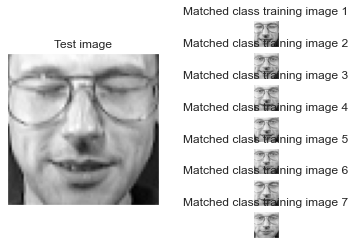

In [61]:
%matplotlib inline
X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7) # split into training and testing
pca = decomposition.PCA(n_components=20) # use PCA to reduce the dimension to 20
pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(DecisionTreeClassifier(), T=10).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])